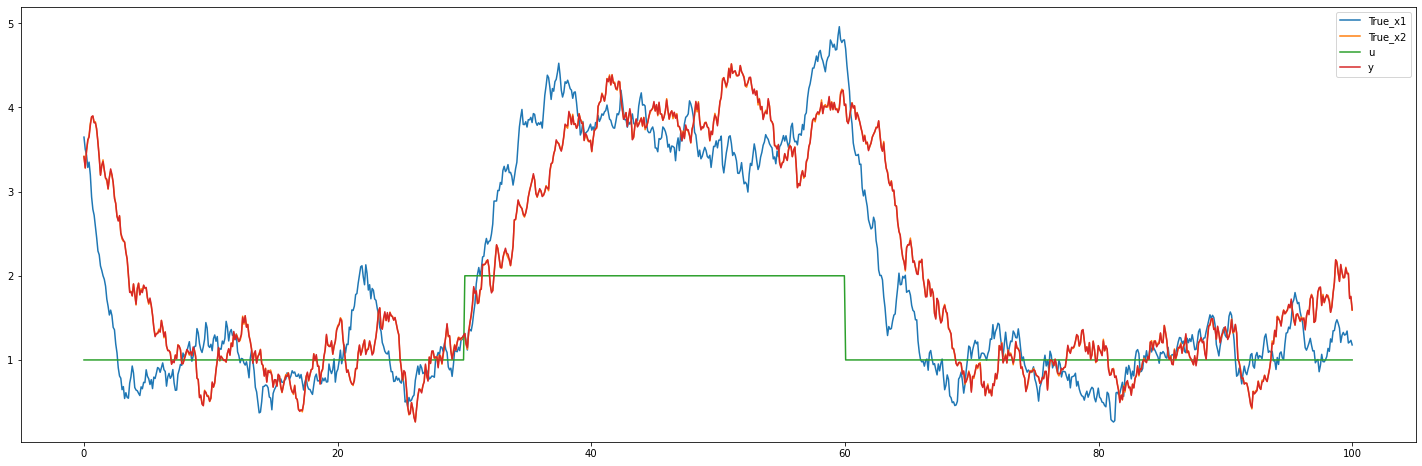

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

true_x1 = pd.read_csv('True_state_x1_nonlinear_case.txt',sep=" ", header=0)['True']
true_x2 = pd.read_csv('True_state_x2_nonlinear_case.txt',sep=" ", header=0)['True']
command = pd.read_csv('Input_nonlinear_case.txt',sep=" ", header=0)['input']
mes = pd.read_csv('Measured_output_nonlinear_case.txt',sep=" ", header=0)['output']

time = np.linspace(0,100,1000)
noise = np.random.normal(0,0.0125) # faut-il ajouter du noise à y ?

plt.figure(figsize=(25,8))
plt.plot(time,true_x1, label="True_x1")
plt.plot(time,true_x2, label="True_x2")
plt.plot(time,command, label="u")
plt.plot(time,mes, label="y")
plt.legend(loc="upper right")
plt.show()


In [2]:
dt=0.1 #seconds
Nsteps = 1000


# Matrices

# Lien step en fonction du step d'avant
A = np.array([[0.9512, 0],   
              [0.0476, 0.9512]])  

# Lien step en fct de la commande
B = np.array([[0.0975],
              [0.0024]])

# Lien mesure en fct de l'état
C = np.array([0, 1])

# Covariance de l'état initial
P0 = np.array([[1, 0],
               [0, 1]])

# Process noise (=W)
mean = (0, 0)
Q = np.array([[0.009506, 0.000234],   
              [0.000234, 0.009506]]) 



# Measurement noise (1x1)
R = 0.0125

#number of steps 

N = 20


# Initial states
init =  np.empty((N, 2 , 1), dtype=float)
for i in range(N - 1):
    x1_0 = 5 + np.random.normal(0, 1)
    x2_0 = 5 + np.random.normal(0, 1)
    init[i , :, :] = np.array([[x1_0],
                [x2_0]])



# Initial states




print(init)




[[[5.53999534]
  [3.77541589]]

 [[7.68227821]
  [5.91766252]]

 [[3.81398551]
  [7.2006898 ]]

 [[6.08703338]
  [6.07846807]]

 [[5.22038364]
  [3.48942768]]

 [[4.96954533]
  [4.33108239]]

 [[6.25581972]
  [5.24418294]]

 [[6.30558958]
  [4.50153152]]

 [[3.67001601]
  [4.03448198]]

 [[4.17183977]
  [5.71420576]]

 [[5.1287963 ]
  [5.84850651]]

 [[5.15738758]
  [4.11870928]]

 [[5.88062754]
  [4.39693773]]

 [[5.64690775]
  [4.96229497]]

 [[2.92236327]
  [5.07383619]]

 [[4.78922129]
  [4.20234324]]

 [[5.51086827]
  [5.09776652]]

 [[5.1939732 ]
  [5.24490396]]

 [[5.14962891]
  [5.1591862 ]]

 [[0.        ]
  [0.        ]]]


In [43]:
def f(x , u):
    x1 = x[0, 0]
    x2 = x[1, 0]
    f1 = np.sqrt(x1) + u
    f2 = np.sqrt(x1) - np.sqrt(x2)
    return(np.array([[f1],
            [f2]]))

In [44]:
def EnKalman_predictor(A, B, Q, init, P0, C, R, Measurements, command, Nsteps, N, h):
    
    # Output : 
    # - Predicted_states, a Nsteps x 2 array containing the states at all time indexes
    
    K = np.empty((Nsteps, 2, 1), dtype=float)
    P = np.empty((Nsteps, 2, 2), dtype=float)
    Ptilde = np.empty((Nsteps, 2, 2), dtype=float)
    mu = np.empty((Nsteps, N, 2, 1), dtype=float)
    
    P[0, :, :] = P0
    mu[0, :, :] = init; 
    print(mu[0, 0, :, :])
    for k in range(Nsteps-1):
        
        
        K[k, :, :] = (P[k, :, :] @ C.T) @ C.T * 1/(C @ P[k, :, :] @ C.T + R)
        
        Ptilde[k,: , :] = A @ P[k, : , :] @ A.T + Q 
        
        P[k+1, :, :] =  Ptilde[k , : , :] @ C.T - K[k , : , : ] * C @ Ptilde[ k ,: , :]
        
        for i in range(N):
            f1 = f(mu[k, i , :, :], command[k])
            f2 = f(mu[k, i , :, :] + 1*f1/2 , command[k])
            f3 = f(mu[k, i , :, :] + h*f2/2 , command[k])
            f4 = f(mu[k, i , :, :] + h*f3 , command[k])
            mu_tild = A @ mu[k, i , : , :] + (h/6) * (f1 + 2*f2 + 2*f3 + f4)   # (2*1)
            mu[k+1, i, : , :] = mu_tild + K[k, : , :] * (Measurements[k] - C @ mu_tild)
      
    return mu

In [45]:
def Moyenne(pred_states, Nsteps):
    
    tab = np.empty((Nsteps, 2, 1), dtype=float)
    for k in range(Nsteps) :
        tab[k, 0 , : ] = pred_states[k, : , 0, :].mean()
        tab[k, 1 , : ] = pred_states[k, : , 1, :].mean()
    
    return(tab)
    

[[5.53999534]
 [3.77541589]]


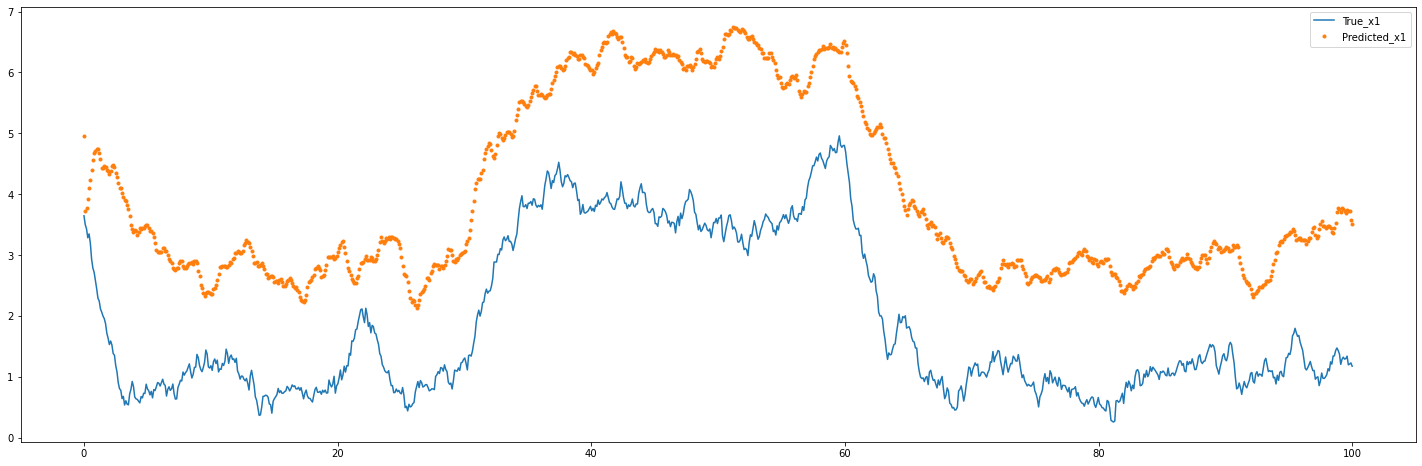

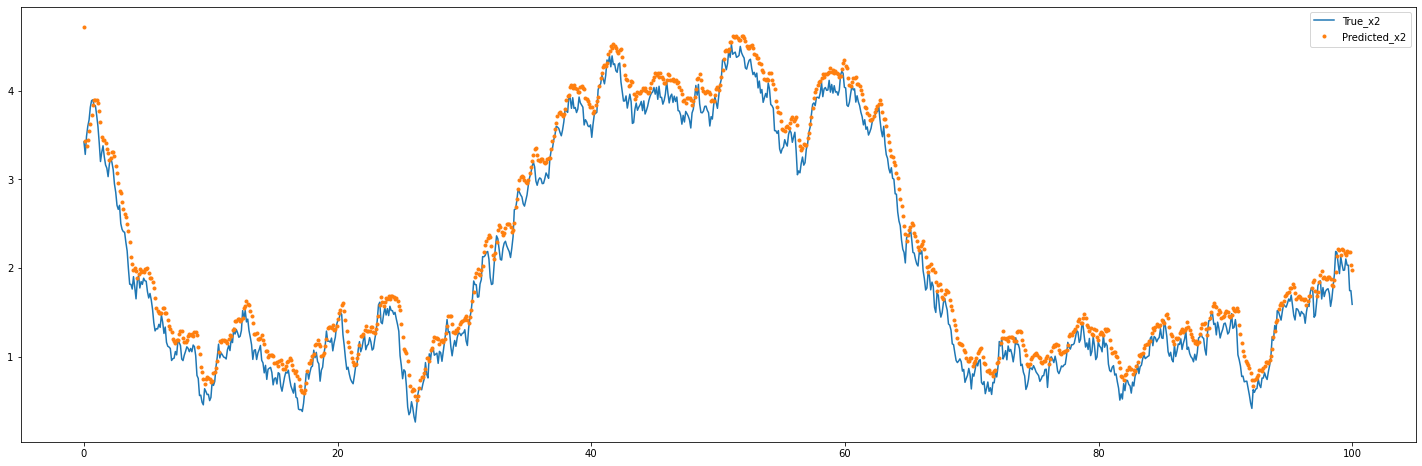

In [42]:
pred_states = EnKalman_predictor(A, B, Q, init, P0, C, R, mes, command, Nsteps, N, dt)

pred_states_moy = Moyenne(pred_states, Nsteps)


plt.figure(figsize=(25,8))
plt.plot(time,true_x1, label="True_x1")
plt.plot(time, pred_states_moy[:,0], ".",label="Predicted_x1")
plt.legend(loc="upper right")
plt.show()
plt.figure(figsize=(25,8))
plt.plot(time,true_x2, label="True_x2")
plt.plot(time, pred_states_moy[:,1], ".",label="Predicted_x2")
plt.legend(loc="upper right")
plt.show()
